#**Amazon Stock Market Predictions - Data Science Final Project**
#**Hana Meah - 16048117**
##**GRU model**
##Part 2 out of 3 code files
##File 1 : LSTM model - train from scratch option 1
##File 2 : GRU model - train from scratch option 2
##File 3 : Prophet - pretrained option

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import GRU, Dense, Dropout
from keras.utils import plot_model
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras import losses, optimizers

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Set the seed to generate the same sequence of randomness during multiple executions of the notebook.
seed = 25
set_random_seed(seed)

# Load Amazon stock data from Yahoo Finance from 2001-01-02 to 2024-07-08
ticker = "AMZN"
df = yf.download(ticker, start="2001-01-02", end="2024-07-08")

# Drop any rows with NaN values
df.dropna(inplace=True)

# Preprocess the data by min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

# Create the time series data
look_back = 30  # Look back period is one month.

# Use 80% of data for training and 20% for testing
train_size = int(len(scaled_data) * 0.80)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - look_back:]

# Generate training and testing sequences of data
train_generator = TimeseriesGenerator(train_data, train_data,
                                     length=look_back, batch_size=32)
test_generator = TimeseriesGenerator(test_data, test_data,
                                     length=look_back, batch_size=1)

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.reset_index(inplace=True)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,0.790625,0.800000,0.681250,0.693750,0.693750,184070000
1,2001-01-03,0.681250,0.893750,0.678125,0.878125,0.878125,293608000
2,2001-01-04,0.850000,0.878125,0.771875,0.775000,0.775000,212410000
3,2001-01-05,0.775000,0.793750,0.678125,0.728125,0.728125,175976000
4,2001-01-08,0.721875,0.778125,0.687500,0.746875,0.746875,208894000
...,...,...,...,...,...,...,...
5908,2024-06-28,197.729996,198.850006,192.500000,193.250000,193.250000,76930200
5909,2024-07-01,193.490005,198.300003,192.820007,197.199997,197.199997,41192000
5910,2024-07-02,197.279999,200.429993,195.929993,200.000000,200.000000,45600000
5911,2024-07-03,199.940002,200.029999,196.759995,197.589996,197.589996,31597900


In [ ]:
# Initialize the sequential model
GRU_model = Sequential()

# Add the first GRU layer with L2 regularization
GRU_model.add(GRU(units=50, return_sequences=True,
              input_shape=(look_back, 1),
              kernel_regularizer=l2(0.01),
              recurrent_regularizer=l2(0.01)))
GRU_model.add(Dropout(0.2))

# Add the second GRU layer with L2 regularization
GRU_model.add(GRU(units=80, return_sequences=True,
              kernel_regularizer=l2(0.01),
              recurrent_regularizer=l2(0.01)))
GRU_model.add(Dropout(0.3))

# Add the third GRU layer with L2 regularization
GRU_model.add(GRU(units=100, return_sequences=False,
              kernel_regularizer=l2(0.01),
              recurrent_regularizer=l2(0.01)))
GRU_model.add(Dropout(0.3))

# Add a Dense output layer
GRU_model.add(Dense(1))

# Compile the model
GRU_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = GRU_model.fit(train_generator, epochs=100, validation_data=test_generator, callbacks=[early_stopping])

Epoch 1/100
  1/147 ━━━━━━━━━━━━━━━━━━━━ 45:01 19s/step - loss: 4.5636 - mean_absolute_error: 0.3855

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


147/147 ━━━━━━━━━━━━━━━━━━━━ 49s 206ms/step - loss: 2.3108 - mean_absolute_error: 0.0775 - val_loss: 0.2074 - val_mean_absolute_error: 0.2988
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 39s 197ms/step - loss: 0.0687 - mean_absolute_error: 0.0491 - val_loss: 0.1778 - val_mean_absolute_error: 0.3932
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 208ms/step - loss: 0.0201 - mean_absolute_error: 0.0667 - val_loss: 0.0413 - val_mean_absolute_error: 0.1546
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 28s 193ms/step - loss: 0.0177 - mean_absolute_error: 0.0433 - val_loss: 0.2000 - val_mean_absolute_error: 0.4254
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 28s 190ms/step - loss: 0.0159 - mean_absolute_error: 0.0489 - val_loss: 0.0404 - val_mean_absolute_error: 0.1587
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 28s 190ms/step - loss: 0.0157 - mean_absolute_error: 0.0498 - val_loss: 0.0638 - val_mean_absolute_error: 0.2206
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 27s 186ms/step - loss: 0.0147 - mean_absolute_e

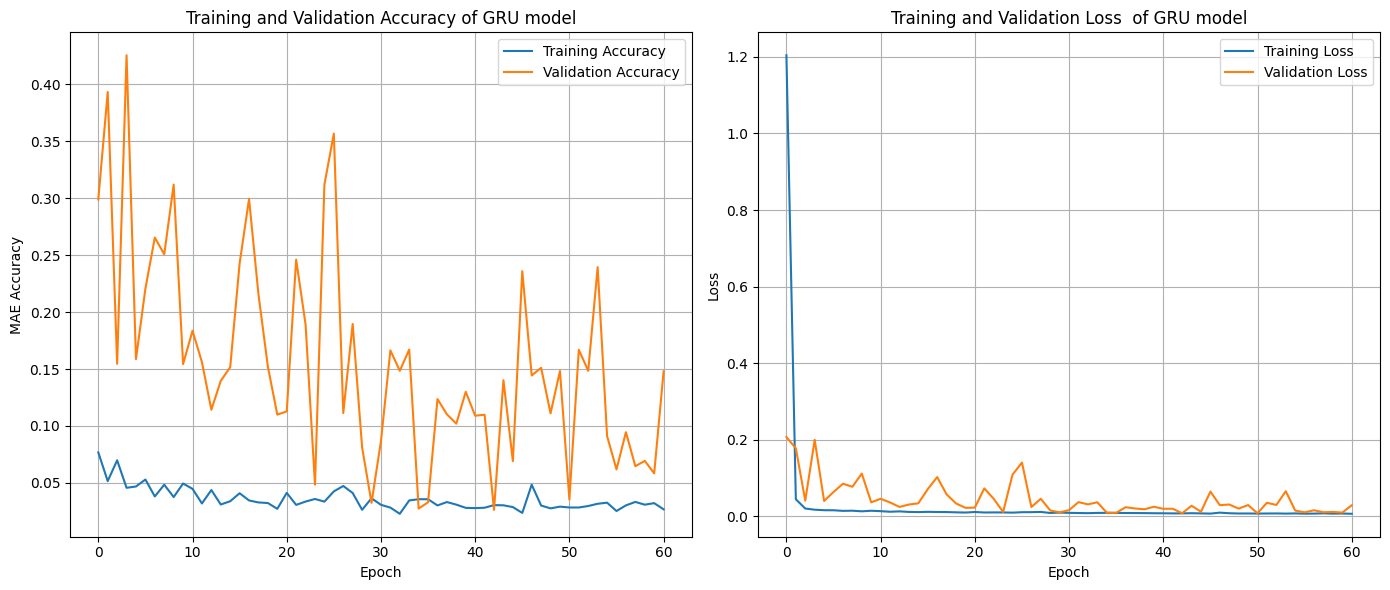

In [22]:
# Create a 1x2 subplot layout
plt.figure(figsize=(14, 6))

# First subplot: MAE accuaracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history.history['mean_absolute_error'], label='Training Accuracy')
plt.plot(history.history['val_mean_absolute_error'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy of GRU model')
plt.xlabel('Epoch')
plt.ylabel('MAE Accuracy')
plt.legend()
plt.grid(True)

# Second subplot: Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss  of GRU model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()


In [ ]:
# Evaluate the model on the test data
loss, mae = GRU_model.evaluate(test_generator)
print(f'Test Loss (MSE): {loss}')
print(f'Test MAE: {mae}')

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 0.0080 - mean_absolute_error: 0.0321
Test Loss (MSE): 0.008291827514767647
Test MAE: 0.03542434424161911


In [14]:
# Make predictions
predictions = GRU_model.predict(test_generator)
predictions = scaler.inverse_transform(predictions)

predictions = predictions[look_back:]   # Shifting by a look_back number of days

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step


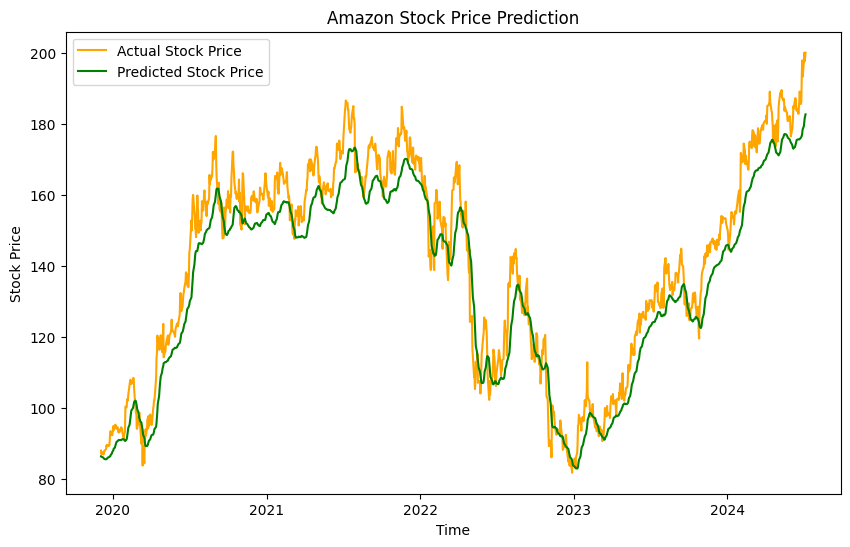

In [15]:
# Plot the predictions
test_data = df['Close'][train_size:].values[look_back:]
plt.figure(figsize=(10, 6))

# Extract the dates corresponding to the test period
test_dates = df['Date'][train_size + look_back:].values
predictions = predictions[:len(test_dates)]

plt.plot(test_dates, test_data, color='orange', label='Actual Stock Price')
plt.plot(test_dates, predictions, color='green', label='Predicted Stock Price')
plt.title('Amazon Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [20]:
# Define the last date I want the future predictions from
last_date = pd.Timestamp('2024-07-08')

# Number of days I want to predict into the future
days_future = 5

# Prepare the latest data from the most recent days for prediction
latest_data = scaled_data[-look_back:]
future_predictions = []

# Predict future values of the Amazon stock prices
for _ in range(days_future):
    prediction = GRU_model.predict(latest_data.reshape(1, look_back, 1))
    future_predictions.append(prediction[0, 0])
    # Update latest data
    latest_data = np.append(latest_data[1:], prediction, axis=0)

# Inverse transform the future predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Prepare future dates starting from July 9, 2024
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=days_future, freq='D')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


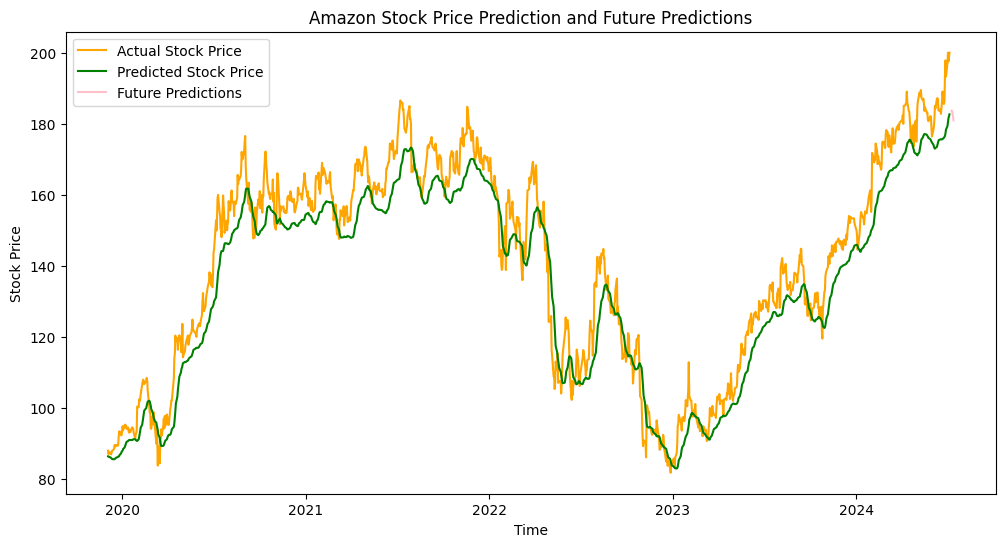

In [21]:
# Plot the future predictions
plt.figure(figsize=(12, 6))
#plt.plot(df["Date"], df["Close"], label='Close Price', color='orange')
plt.plot(test_dates, test_data, color='orange', label='Actual Stock Price')
plt.plot(test_dates, predictions, color='green', label='Predicted Stock Price')
plt.plot(future_dates, future_predictions, color='pink', label='Future Predictions')
plt.title('Amazon Stock Price Prediction and Future Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()